In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
import requests
from PIL import Image
import matplotlib.pyplot as plt
from datasets import load_dataset

c:\Projects\image-captioning-conceptual-captions\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
dataset = load_dataset("conceptual_captions", split="train[:200]")
len(dataset)

200

In [4]:
image = None
caption_text = None

for i in range(len(dataset)):
    sample = dataset[i]
    try:
        image = Image.open(
            requests.get(sample["image_url"], stream=True, timeout=5).raw
        ).convert("RGB")
        caption_text = sample["caption"]
        break
    except:
        continue

image, caption_text

(<PIL.Image.Image image mode=RGB size=500x441>,
 'sierra looked stunning in this top and this skirt while performing with person at their former university')

In [5]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

image_tensor = transform(image).unsqueeze(0).to(device)
image_tensor.shape

torch.Size([1, 3, 224, 224])

In [6]:
cnn = models.resnet18(pretrained=True)
cnn = nn.Sequential(*list(cnn.children())[:-1])
cnn.eval()
cnn.to(device)

c:\Projects\image-captioning-conceptual-captions\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Projects\image-captioning-conceptual-captions\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [7]:
with torch.no_grad():
    features = cnn(image_tensor)

features = features.squeeze(-1).squeeze(-1)
features.shape

torch.Size([1, 512])

In [8]:
vocab_size = 1000
caption_tokens = torch.randint(0, vocab_size, (1, 5)).to(device)
caption_tokens

tensor([[160, 555, 647,  99,  56]])

In [11]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, feature_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.fc_image = nn.Linear(feature_size, embed_size)
        self.rnn = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, image_features, captions):
        embeddings = self.embed(captions)
        image_features = self.fc_image(image_features)
        image_features = image_features.unsqueeze(1)
        inputs = torch.cat((image_features, embeddings), dim=1)
        outputs, _ = self.rnn(inputs)
        return self.fc(outputs)

In [12]:
decoder = RNNDecoder(
    embed_size=256,
    hidden_size=512,
    vocab_size=vocab_size,
    feature_size=512
).to(device)
outputs = decoder(features, caption_tokens)
outputs.shape

torch.Size([1, 6, 1000])

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3)

outputs = outputs[:, 1:, :]

loss = criterion(
    outputs.reshape(-1, vocab_size),
    caption_tokens.reshape(-1)
)

loss.backward()
optimizer.step()
optimizer.zero_grad()

loss.item()

6.861917018890381

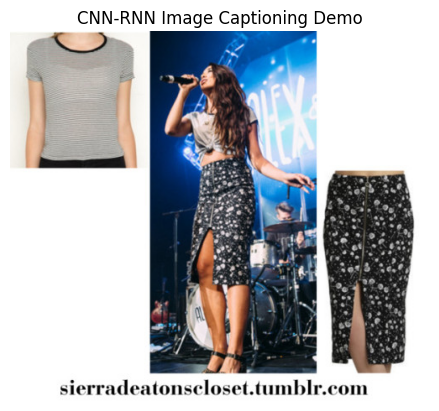

Ground Truth Caption:
sierra looked stunning in this top and this skirt while performing with person at their former university

Generated Output (token-level, illustrative):
[160, 555, 647, 99, 56]


In [15]:
plt.imshow(image)
plt.axis("off")
plt.title("CNN-RNN Image Captioning Demo")
plt.show()

print("Ground Truth Caption:")
print(caption_text)

print("\nGenerated Output (token-level, illustrative):")
print(caption_tokens[0].tolist())